<a href="https://colab.research.google.com/github/bintangnabiil/Deep_Learning/blob/main/Deep_Learning_GRU_Model_Week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1) Model GRU Pytorch

##1. Import Library

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##2. Load dan Preprocessing Dataset

In [9]:
df = pd.read_csv('/content/ReviewTokoBaju.csv')
df = df[['Review Text', 'Recommended IND']].dropna()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df['clean'] = df['Review Text'].apply(clean_text)
df = df[df['clean'].str.strip().astype(bool)]
tokenized = []
for text in df['clean']:
    try:
        tokenized.append(word_tokenize(text))
    except:
        tokenized.append([])

all_words = [word for tokens in tokenized for word in tokens]
word_counts = Counter(all_words)
vocab = {w: i+2 for i, (w, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

MAX_LEN = 100
def encode(tokens):
    encoded = [vocab.get(t, 1) for t in tokens]
    return encoded[:MAX_LEN] + [0]*(MAX_LEN - len(encoded))

encoded_texts = [encode(toks) for toks in tokenized]
labels = df['Recommended IND'].tolist()

X_train, X_test, y_train, y_test = train_test_split(encoded_texts, labels, test_size=0.2, random_state=42)

##3. Dataset dan Dataloader

In [10]:
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ReviewDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(ReviewDataset(X_test, y_test), batch_size=64)

##4. GRU Model

In [11]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        embedded = self.embedding(x)
        _, h_n = self.gru(embedded)
        out = self.fc(h_n[-1])
        return self.sigmoid(out).squeeze()

model = GRUClassifier(len(vocab), 64, 128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

##5. Training Loop

In [12]:
train_losses, test_losses = [], []
for epoch in range(5):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    test_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={test_losses[-1]:.4f}")


Epoch 1: Train Loss=0.4842, Val Loss=0.4707
Epoch 2: Train Loss=0.4753, Val Loss=0.4706
Epoch 3: Train Loss=0.4743, Val Loss=0.4775
Epoch 4: Train Loss=0.4749, Val Loss=0.4706
Epoch 5: Train Loss=0.4748, Val Loss=0.4760


##6. Evaluasi

In [13]:
pred_probs = np.array(all_preds)
pred_labels = (pred_probs > 0.5).astype(int)
y_true = np.array(all_targets)

print("Accuracy :", accuracy_score(y_true, pred_labels))
print("Precision:", precision_score(y_true, pred_labels))
print("Recall   :", recall_score(y_true, pred_labels))
print("F1 Score :", f1_score(y_true, pred_labels))
print("AUC      :", roc_auc_score(y_true, pred_probs))

Accuracy : 0.8207109737248841
Precision: 0.8207109737248841
Recall   : 1.0
F1 Score : 0.9015280135823429
AUC      : 0.5


##7. Visualisasi Loss

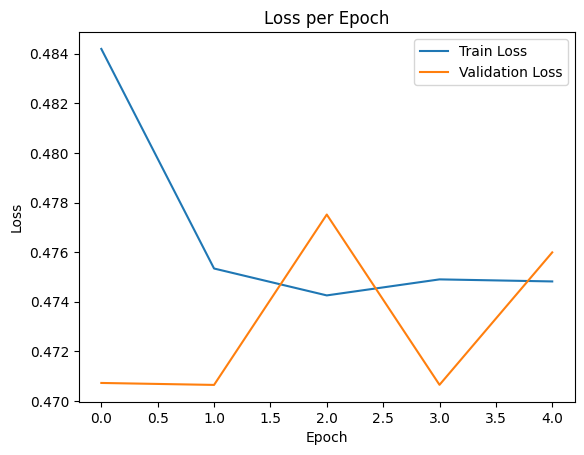

In [14]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

##8. ROC Curve

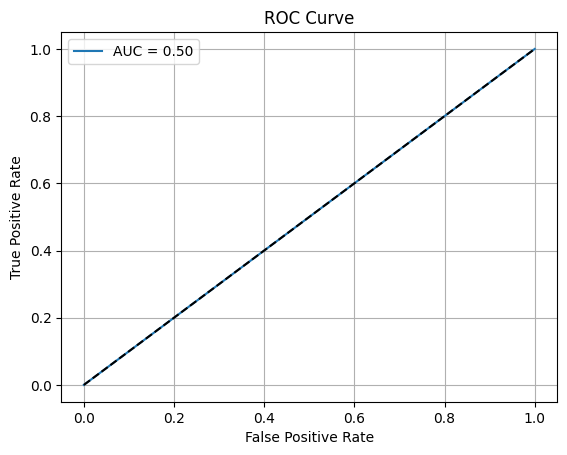

In [15]:
fpr, tpr, _ = roc_curve(y_true, pred_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, pred_probs):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

#2) Model GRU TensorFlow

##1. Import Library

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

import nltk
from nltk.tokenize import word_tokenize
import re
import string

##2. Clean Text Function

In [17]:
def bersihkan_teks(teks):
    if pd.isnull(teks):
        return ""
    teks = teks.lower()
    teks = re.sub(r'https?://\S+|www\.\S+', '', teks)
    teks = re.sub(r'[^a-zA-Z\s]', '', teks)
    teks = re.sub(r'\s+', ' ', teks).strip()
    return teks

##3. Load Data

In [18]:
data_review = pd.read_csv('/content/ReviewTokoBaju.csv')

##4. Clean dan Tokenisasi

In [19]:
data_review['teks_bersih'] = data_review['Review Text'].apply(bersihkan_teks)
data_review = data_review[data_review['teks_bersih'].str.strip().astype(bool)]

token_gru = Tokenizer()
token_gru.fit_on_texts(data_review['teks_bersih'])

urutan_kata = token_gru.texts_to_sequences(data_review['teks_bersih'])
indeks_kata = token_gru.word_index
jumlah_kata = len(indeks_kata) + 1

panjang_maks = max(len(seq) for seq in urutan_kata)
urutan_pad = pad_sequences(urutan_kata, maxlen=panjang_maks, padding='post')


##5. Labeling Review

In [20]:
label_sentimen = data_review['Rating'].apply(lambda nilai: 1 if nilai >= 4 else 0).values


##6. Split Data

In [21]:
input_latih, input_uji, label_latih, label_uji = train_test_split(
    urutan_pad, label_sentimen, test_size=0.2, random_state=42
)

##7. Arsitektur Model GRU

In [22]:
model_gru = Sequential([
    Embedding(input_dim=jumlah_kata, output_dim=128, input_length=panjang_maks),
    GRU(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_gru.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


##8. Training

In [23]:
histori_gru = model_gru.fit(
    input_latih, label_latih,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
    verbose=1
)

Epoch 1/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 60s 124ms/step - accuracy: 0.7782 - auc: 0.4968 - loss: 0.5456 - val_accuracy: 0.7566 - val_auc: 0.5001 - val_loss: 0.5560
Epoch 2/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - accuracy: 0.7716 - auc: 0.5002 - loss: 0.5406 - val_accuracy: 0.7566 - val_auc: 0.4995 - val_loss: 0.5564
Epoch 3/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 81s 120ms/step - accuracy: 0.8084 - auc: 0.6937 - loss: 0.4588 - val_accuracy: 0.8703 - val_auc: 0.9133 - val_loss: 0.3266
Epoch 4/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 82s 122ms/step - accuracy: 0.9039 - auc: 0.9431 - loss: 0.2439 - val_accuracy: 0.8730 - val_auc: 0.9239 - val_loss: 0.3338
Epoch 5/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 81s 121ms/step - accuracy: 0.9424 - auc: 0.9712 - loss: 0.1652 - val_accuracy: 0.8730 - val_auc: 0.9199 - val_loss: 0.3059
Epoch 6/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 56s 124ms/step - accuracy: 0.9572 - auc: 0.9853 - loss: 0.1231 - val_accuracy: 0.8722 - val_auc: 0.9085 - val_loss: 0.4053
Epoch 7/10
453/453 ━━━

##9. Evaluasi Model

In [24]:
prediksi_prob = model_gru.predict(input_uji).ravel()
prediksi_label = (prediksi_prob >= 0.5).astype(int)

print("Akurasi  :", accuracy_score(label_uji, prediksi_label))
print("Presisi  :", precision_score(label_uji, prediksi_label))
print("Recall   :", recall_score(label_uji, prediksi_label))
print("F1 Score :", f1_score(label_uji, prediksi_label))
print("AUC      :", roc_auc_score(label_uji, prediksi_prob))
print("\nLaporan Klasifikasi:\n", classification_report(label_uji, prediksi_label))


142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Akurasi  : 0.8763523956723338
Presisi  : 0.9262390670553936
Recall   : 0.9118828932261768
F1 Score : 0.9190049175585768
AUC      : 0.9299330088607386

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.72      0.76      0.74      1045
           1       0.93      0.91      0.92      3484

    accuracy                           0.88      4529
   macro avg       0.82      0.83      0.83      4529
weighted avg       0.88      0.88      0.88      4529



##10. Visualisasi Akurasi & Loss

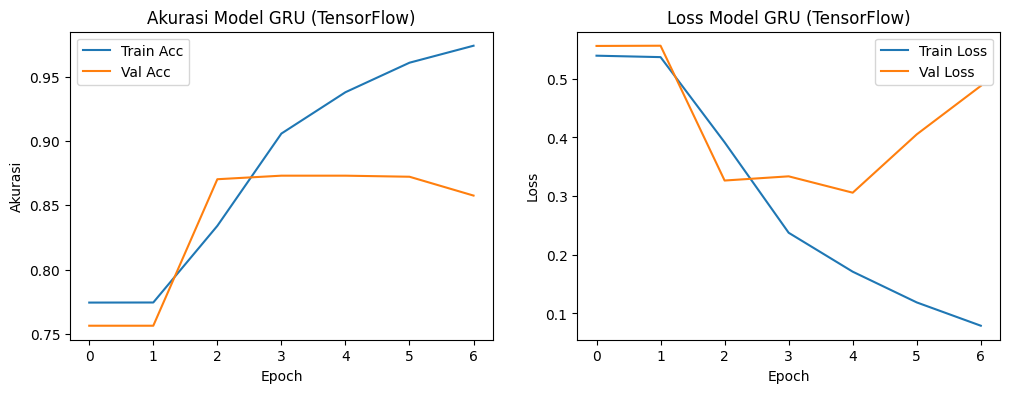

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(histori_gru.history['accuracy'], label='Train Acc')
plt.plot(histori_gru.history['val_accuracy'], label='Val Acc')
plt.title('Akurasi Model GRU (TensorFlow)')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(histori_gru.history['loss'], label='Train Loss')
plt.plot(histori_gru.history['val_loss'], label='Val Loss')
plt.title('Loss Model GRU (TensorFlow)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##11. ROC Curve

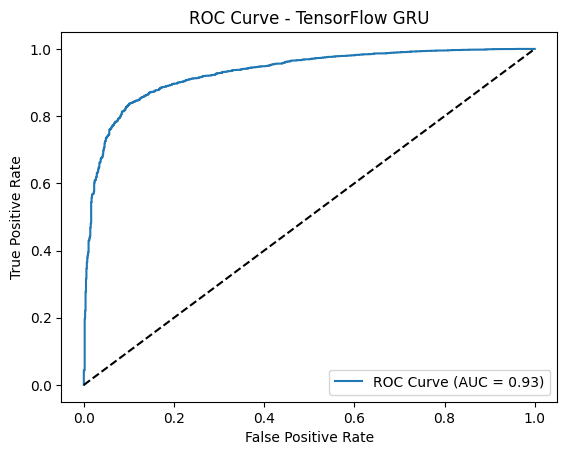

In [26]:
fpr_tf, tpr_tf, _ = roc_curve(label_uji, prediksi_prob)
plt.figure()
plt.plot(fpr_tf, tpr_tf, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(label_uji, prediksi_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TensorFlow GRU')
plt.legend()
plt.show()

#3) Penjelasan Persamaan Matematika
##1. Update Gate
Mengontrol seberapa banyak informasi dari waktu sebelumnya yang diteruskan.
$$
z_t = \sigma(W_zx_t + U_zh_{t-1} +b_z)
$$

Keterangan:
- $x_t$ = input saat ini (kata yang sedang diproses)
- $h_{t-1}$ = hidden state dari waktu sebelumnya
- $W_z, Uz, b_z$ = parameter trainable
- $\sigma$ = parameter trainable<br><br>

##2. Reset Gate
Menentukan seberapa banyak informasi masa lalu yang ingin dilupakan.
$$
r_t = \sigma(W_rx_t + U_rh_{t-1} +b_r)
$$<br><br>

##3. Candidate Hidden State
Kandidat nilai baru untuk hidden state.
$$
\overline{h}_t = tanh(W_hx_t + U_h(r_t⊙h_{t-1} +b_h))
$$<br><br>

##4. Hidden State Baru
Nilai hidden state akhir yang digunakan untuk memprediksi.
$$
h_t = (1-z_t)⊙h_{t-1}+z_t⊙\overline{h}_t
$$<br><br>

##5. Output Layer (Sigmoid untuk Binary Classification)
Output akhir ini menghasilkan probabilitas antara 0 dan 1 (misal: 0.82 → 82% positif)
$$
\hat{y} = \sigma(W_oh_t+b_o)
$$<br><br>

##6. Loss Function (Binary Cross Entropy)
Untuk Meminimalkan selisih prediksi vs realitas
$$
𝓛_{BCE}(y,\hat{y})=-[y \cdot log(\hat{y})+(1-y) \cdot log(1-\hat{y})]
$$

Keterangan:
- $y$ = label sebenarnya (0 atau 1)
- $\hat{y}$ = prediksi model
<br><br>

##7. Akurasi
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$<br><br>

Di mana:
- $TP (True Positive)$ = Kasus positif yang diprediksi positif
- $TF (True Negative)$ = Kasus negatif yang diprediksi negatif
- $FP (False Positive)$ = Kasus negatif yang salah diprediksi sebagai positif
- $FF (False Negative)$ = Kasus positif yang salah diprediksi sebagai negatif<br><br>

##8. Presisi
$$
Presisi = \frac{TP}{TP + FP}
$$
 Seberapa tepat model saat memprediksi "positif"<br><br>

##9. Recall
$$
Recall = \frac{TP}{TP + FN}
$$
 Seberapa baik model menangkap semua data "positif"<br><br>

##10. F1-Score
$$
F1-Score = 2 \times \frac{Precision×Recall}{Precision+Recall}
$$
Kombinasi harmonis antara presisi dan recall<br><br>

##11. AUC - ROC
Mengukur kemampuan model membedakan kelas 0 dan 1. ROC = kurva antara True Positive Rate vs False Positive Rate
$$
TPR = \frac{TP}{TP + FN}
$$
$$
FPR = \frac{FP}{FP + TN}
$$
AUC berada antara 0–1. Semakin mendekati 1 → semakin baik klasifikasinya.
<br><br>


